## Objetivo
Gerar ilustrações para as características de cada defeito. Serão selecionadas amostras com a maior severidade de defeito, na maior rotação.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

NORMAL = '../mafaulda/normal/56.7296.csv'
DESBALANCEAMENTO = '../mafaulda/imbalance/35g/56.7296.csv'
DESALINHAMENTO_VERTICAL = '../mafaulda/vertical-misalignment/1.90mm/56.7296.csv'
DESALINHAMENTO_HORIZONTAL = '../mafaulda/horizontal-misalignment/2.0mm/56.32.csv'
EIXO = 'tg1'

NOMES_DEFEITOS = (['normmal', 'desbalanceamento', 'dealinhamento vertical', 'desalinhamento horizontal'])
FREQUENCIA = 'frequencia_Hz'

CAMINHOS = [NORMAL, DESBALANCEAMENTO, DESALINHAMENTO_VERTICAL, DESALINHAMENTO_HORIZONTAL]


In [55]:
def extract_fundamental(fft_df):
    # dentre os 3 maiores picos na fft do tacômetro, deve retornar o de menor frequência
    # assim, evita-se o mascaramento da fundamental pelas harmonicas

    candidates = [0, 0, 0]
    for i in range(3):
        index = fft_df['tacômetro'].argmax()
        candidates[i] = fft_df.loc[index, FREQUENCIA]
        for j in range(-2, 3):
            fft_df['tacômetro'][index+j] = 0

    return min(candidates)

In [56]:
# reduz o samplig frequency 'ratio' vezes, tomando apenas 1 a cada 'ratio' sinais
ratio = 50
sampling_freq=50000/ratio

# poupa apenas as linhas múltiplas de 'ratio' e lista as demais para exclusão
skip=[i for i in range(0,250000) if i%ratio] 

# lê dados no tempo
dataframes = []
arg_fundamentais = []
for i, exemplar in enumerate(CAMINHOS):
    signals = pd.read_csv(exemplar, header=None, 
                        names=['tacômetro','ax1','rad1','tg1','ax2','rad2','tg2','microfone'],
                        skiprows=skip)


    # seleciona os eixos de interesse
    signals = signals[['tacômetro', EIXO]]

    # transformada de Fourrier, converte para valores absolutos 
    fft = signals.apply(np.fft.rfft, axis=0, norm="ortho")
    
    # adiciona eixo da frequência
    # OBS: a frequência de Nyquist é sampling_freq/2
    fft[FREQUENCIA] = np.linspace(0, sampling_freq/2+1, fft.shape[0])
    fft['Amplitude'] = fft[EIXO].apply(np.abs)
    fft['Fase'] = fft[EIXO].apply(np.angle, deg=True)
    
    # encontra a rotação
    fundamental = extract_fundamental(fft)
    # extrai o index da fundamental
    index = fft.index[fft[FREQUENCIA] == fundamental]

    # encontra o ângulo de fase do tacômetro
    fft_ang_taco = fft['tacômetro'].apply(np.angle, deg=True)
    ref_angle = fft_ang_taco.loc[index]
    print('Ângulo de referência:', ref_angle.values[0])

    fft.pop('tacômetro')
    fft.pop(EIXO)
    
    arg_fundamentais.append(index)
    dataframes.append(fft)


print("\na frequência de aquisição foi reduzida de 50kHz para {}kHz\n".format(sampling_freq/1000))

Ângulo de referência: 0.0
Ângulo de referência: 0.0
Ângulo de referência: 0.0
Ângulo de referência: 0.0

a frequência de aquisição foi reduzida de 50kHz para 1.0kHz



In [57]:
df = pd.concat(dataframes, 
          keys=NOMES_DEFEITOS, 
          names=['defeito', 'index']
).reset_index()

df.pop('index');

list(df.columns)

['defeito', 'frequencia_Hz', 'Amplitude', 'Fase']

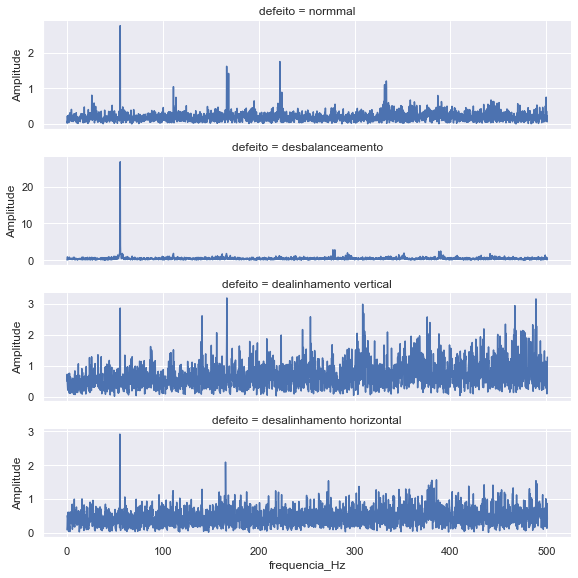

In [58]:
sns.relplot(data=df, x=FREQUENCIA, y='Amplitude', row='defeito', kind='line', facet_kws={'sharey': False, 'sharex': True}, height=2, aspect=4);
print()

In [64]:
for df, defeito, index in zip(dataframes, NOMES_DEFEITOS, arg_fundamentais):
    print('Ângulo para {:25}: {:7.2f} graus'.format(defeito, df.loc[index, 'Fase'].values[0]))

Ângulo para normmal                  :  117.72 graus
Ângulo para desbalanceamento         : -117.02 graus
Ângulo para dealinhamento vertical   :  141.42 graus
Ângulo para desalinhamento horizontal:   50.98 graus
